In [1]:
import torch
import librosa
import numpy as np
import pandas as pd
import librosa
import librosa.display as dsp 
from IPython.display import Audio
import os 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm
from google.colab import drive

In [3]:
drive.mount('/content/MyDrive',force_remount = True)

Mounted at /content/MyDrive


In [4]:
def convert_to_spectogram(raw_data):
    '''converting to spectrogram'''
    spect = librosa.feature.melspectrogram(y=raw_data, n_mels = 64) # n_mels as output shape
    mel_spect = librosa.power_to_db(S=spect, ref=np.max)
    return mel_spect

In [5]:
path = '/content/MyDrive/MyDrive/2022/ECS271Project/'

df = pd.read_csv(path + 'raw_audio_data.csv')
df = df[['features', 'labels']]

In [6]:
df.head()

,features,labels
0,[-6.04037598e+02 1.03272125e+02 -4.01398577e-...,0
1,[-6.38278564e+02 1.07547516e+02 1.51046066e+...,0
2,[-6.2134979e+02 1.0089417e+02 1.6370886e+01 ...,0
3,[-6.3712476e+02 9.5389801e+01 1.6544727e+01 ...,0
4,[-6.3554065e+02 1.0615588e+02 1.1342261e+01 ...,0


In [7]:
def preprocess_vector(x):
  x = x.strip('][').split(' ')
  x = [float(y.strip()) for y in x if y != '']
  return x

df['features'] = df['features'].apply(preprocess_vector, 1)

max_length=20366

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['features'],df['labels'], test_size=0.2,random_state=45,stratify=df['labels'])

In [9]:
X_train.shape

(24000,)

In [10]:
import tensorflow as tf
X_train_pad=tf.keras.preprocessing.sequence.pad_sequences(X_train,maxlen=max_length, dtype='float32')
X_test_pad=tf.keras.preprocessing.sequence.pad_sequences(X_test,maxlen=max_length, dtype='float32')
X_train_mask=np.where(X_train_pad>0.0,True,False)
X_test_mask=np.where(X_test_pad>0.0,True,False)

In [11]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score

In [12]:
X_train_spectrogram=np.array([convert_to_spectogram(np.array([float(i) for i in X_train_pad[k] ])) for k in range(len(X_train_pad)) ])
X_test_spectrogram=np.array([convert_to_spectogram(np.array([float(i) for i in X_test_pad[k] ])) for k in range(len(X_test_pad)) ])

In [13]:
X_train_spectrogram.shape

(24000, 64, 40)

In [14]:
input_layer=Input(shape=(64,40), dtype=np.float32,name='input_layer')
lstm=LSTM(500,name='lstm_layer',return_sequences=True)(input_layer)
d1=Dense(120,activation='relu',name='dense1')(tf.math.reduce_mean(lstm, 2))
d2=Dense(60,activation='relu',name='dense2')(d1)
d3=Dense(10,activation='softmax',name='dense3')(d2)

In [15]:
model = Model(inputs=input_layer, outputs=d3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 40)]          0         
                                                                 
 lstm_layer (LSTM)           (None, 64, 500)           1082000   
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense1 (Dense)              (None, 120)               7800      
                                                                 
 dense2 (Dense)              (None, 60)                7260      
                                                                 
 dense3 (Dense)              (None, 10)                610       
                                                             

In [16]:
def cal_f1(y_true,y_pred):
    return f1_score(y_true,y_pred,average='micro')
def micro_f1(y_true,y_prob):
    y_pred=tf.math.argmax(y_prob,axis=1)
    return tf.py_function(cal_f1,(y_true,y_pred),tf.double)

In [18]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_micro_f1', -1)>0.97:
            self.model.stop_training=True

loss_history=LossHistory()

filepath=path+ "model_save/weights-{epoch:02d}-{micro_f1:.4f}-{val_micro_f1:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_micro_f1',  verbose=1, save_best_only=True, mode='max')

In [19]:
opt= tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' ,metrics=['accuracy',micro_f1])

In [22]:
history = model.fit(X_train_spectrogram,y_train.astype('int')\
           ,validation_data=(X_test_spectrogram,y_test.astype('int'))\
           ,batch_size=32,epochs=400\
           ,callbacks=[loss_history,checkpoint])

Epoch 1/400
750/750 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9276 - micro_f1: 0.9276
Epoch 1: val_micro_f1 did not improve from 0.92221
750/750 [==============================] - 9s 13ms/step - loss: 0.2044 - accuracy: 0.9276 - micro_f1: 0.9276 - val_loss: 0.2327 - val_accuracy: 0.9120 - val_micro_f1: 0.9119
Epoch 2/400
748/750 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9289 - micro_f1: 0.9289
Epoch 2: val_micro_f1 did not improve from 0.92221
750/750 [==============================] - 10s 13ms/step - loss: 0.1990 - accuracy: 0.9289 - micro_f1: 0.9289 - val_loss: 0.2217 - val_accuracy: 0.9207 - val_micro_f1: 0.9205
Epoch 3/400
750/750 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.9312 - micro_f1: 0.9312
Epoch 3: val_micro_f1 did not improve from 0.92221
750/750 [==============================] - 14s 19ms/step - loss: 0.1974 - accuracy: 0.9312 - micro_f1: 0.9312 - val_loss: 0.2308 - val_accuracy: 0.915

In [23]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open(path+'history', 'w'))

In [24]:
opt_res=os.listdir(path + "model_save/")

In [25]:
result=pd.DataFrame()
epoch=[]
f1=[]
val_f1=[]
for i in opt_res:    
    epoch.append(i.split('-')[1])
    f1.append(i.split('-')[2])
    val_f1.append(i.split('-')[3][:6])
result['epoch']=epoch
result['f1']=f1
result['val_f1']=val_f1
values=result[result.epoch==str(result.epoch.astype('int').max())]

In [26]:
print("We have found optimum result at\nEpoch: ",values.iloc[0].epoch,"\nTrain F1 score: ",values.iloc[0].f1,"\nTest F1 score: ",values.iloc[0].val_f1)

We have found optimum result at
Epoch:  387 
Train F1 score:  0.9762 
Test F1 score:  0.9631


In [28]:
history_df = pd.DataFrame(history_dict)

In [29]:
history_df.head()

,loss,accuracy,micro_f1,val_loss,val_accuracy,val_micro_f1
0,0.204436,0.927583,0.927583,0.232650,0.912000,0.911902
1,0.199049,0.928917,0.928917,0.221692,0.920667,0.920545
2,0.197354,0.931208,0.931208,0.230843,0.915167,0.915226
3,0.194847,0.930917,0.930917,0.216833,0.922333,0.922374
4,0.198269,0.930042,0.930042,0.226493,0.918667,0.918717


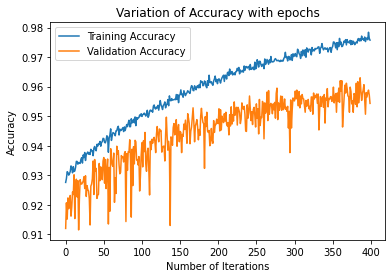

In [30]:
plt.plot(history_df['accuracy'], label = 'Training Accuracy')
plt.plot(history_df['val_accuracy'],label = 'Validation Accuracy')
plt.title('Variation of Accuracy with epochs')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.legend()

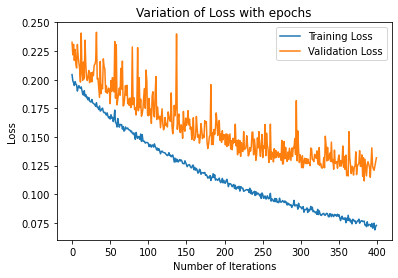

In [33]:
plt.plot(history_df['loss'], label = 'Training Loss')
plt.plot(history_df['val_loss'],label = 'Validation Loss')
plt.title('Variation of Loss with epochs')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()